# Deformed Potentials from Field Dependent Wavefunction Renormalization

In [11]:
# based on: https://arxiv.org/pdf/1811.10655.pdf
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad
from scipy.interpolate import interp1d
#import sympy as sp
#sp.init_printing()
import sys
if ".." not in sys.path: sys.path.append("..")
from common.cosmology import switch_hubble_and_time_rad_dom as switch_hubble_and_time

## General Definitions

In [61]:
def calc_Z(theta, epsilon):
    return 2 / (1 + 2*epsilon**2 - np.cos(theta))

# U = 1 - cos(theta)
# pot = m_a**2 * U
def calc_d_pot_d_theta(theta, m_a):
    return m_a**2 * np.sin(theta)

In [62]:
m_a = 1e-8 # a.u. for now
epsilon = 1e-3
theta_i = 1
# m_a**2 = Gamma**4 / f_a**2
# m_a = Gamma**2 / f_a

In [70]:
theta_range = np.linspace(-np.pi, np.pi, 1000)

Text(0, 0.5, '$Z(\\theta)$')

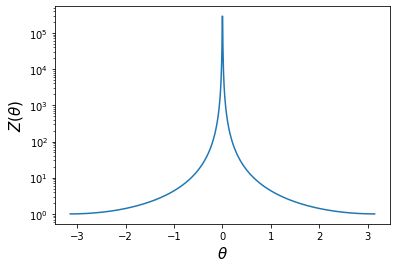

In [71]:
plt.semilogy(theta_range, calc_Z(theta_range, 1e-3))
plt.xlabel(r"$\theta$", fontsize=15)
plt.ylabel(r"$Z(\theta)$", fontsize=15)

## Simulation in $\theta$

In [63]:
def rhs_theta(t, y, m_a, epsilon):
    theta, theta_dot = y
    H = 1 / (2*t)
    Z = calc_Z(theta, epsilon)
    dZdtheta = - 2*np.sin(theta) / (2*epsilon**2 - np.cos(theta) + 1)**2
    dUdtheta = np.sin(theta)
    theta_dotdot = - 1 / (2*Z) * dZdtheta * theta_dot**2 - 3*H*theta_dot - calc_d_pot_d_theta(theta, m_a) / Z
    return theta_dot, theta_dotdot

In [65]:
tspan = (switch_hubble_and_time(m_a * 1e2), switch_hubble_and_time(m_a * 1e-7))
steps = np.geomspace(*tspan, 1000); steps[0] = tspan[0]; steps[-1] = tspan[-1]
sol_theta = solve_ivp(rhs_theta, tspan, [theta_i, 0.0], args=(m_a, epsilon), rtol=1e-8, method="Radau", t_eval=steps)
assert sol_theta.success
t = sol_theta.t; theta, theta_dot = sol_theta.y

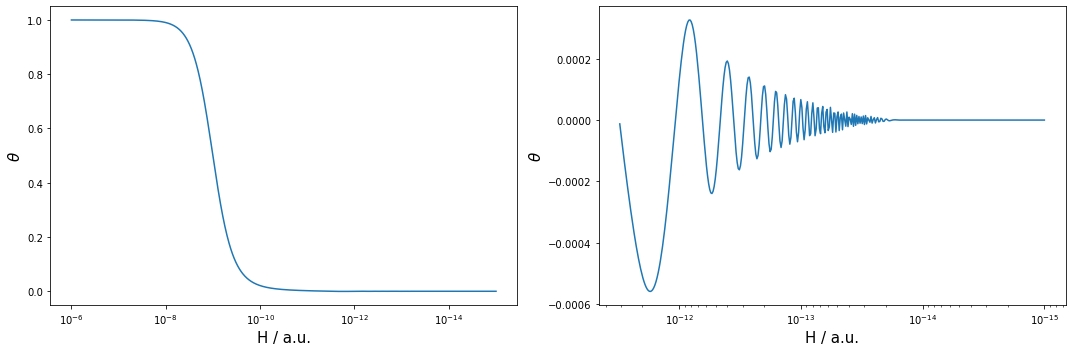

In [4]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.semilogx(switch_hubble_and_time(t), theta)
plt.gca().invert_xaxis()
plt.xlabel("H / a.u.", fontsize=15); plt.ylabel(r"$\theta$", fontsize=15)
plt.subplot(1,2,2)
fst_root_idx = np.where(theta < 0)[0][0]
plt.semilogx(switch_hubble_and_time(t[fst_root_idx:]), theta[fst_root_idx:])
plt.xlabel("H / a.u.", fontsize=15); plt.ylabel(r"$\theta$", fontsize=15)
plt.gca().invert_xaxis()
plt.tight_layout()

## Converting between $\theta$ and $\phi$

In [72]:
def calc_phi_from_theta(theta, epsilon):
    return quad(lambda x: np.sqrt(calc_Z(x, epsilon)), 0, theta)[0]

In [73]:
phis_over_f = [calc_phi_from_theta(theta, epsilon) for theta in theta_range]

Text(0, 0.5, '$\\phi / f_a$')

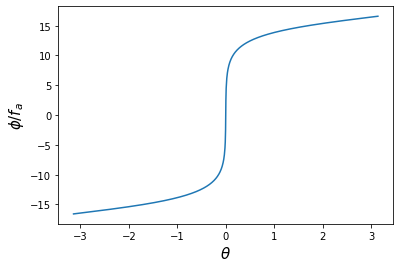

In [74]:
plt.plot(theta_range, phis_over_f)
plt.xlabel("$\\theta$", fontsize=15); plt.ylabel("$\\phi / f_a$", fontsize=15)

In [75]:
theta_to_phi_over_f_fn = interp1d(theta_range, phis_over_f)
phi_over_f_to_theta_fn = interp1d(phis_over_f, theta_range)

## Simulation in $\phi$

In [80]:
def rhs_phi(t, y, m_a):
    phi_over_f, phi_dot_over_f = y
    #print(phi_over_f)
    H = switch_hubble_and_time(t)
    theta = phi_over_f_to_theta_fn(phi_over_f)
    phi_dotdot_over_f = - 3 * H * phi_dot_over_f - calc_d_pot_d_theta(theta, m_a) / np.sqrt(calc_Z(theta, epsilon))
    return phi_dot_over_f, phi_dotdot_over_f

In [81]:
sol = solve_ivp(rhs_phi, tspan, [theta_to_phi_over_f_fn(1.0), 0], t_eval=steps, args=(m_a,))
assert sol.success
t = sol.t
phi_over_f, phi_dot_over_f = sol.y

Text(0, 0.5, '$\\phi / f_a$')

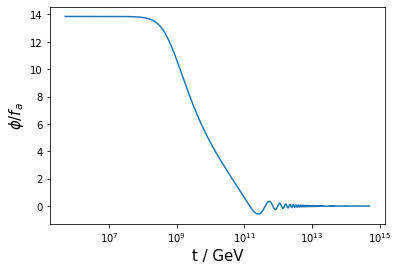

In [82]:
plt.semilogx(t, phi_over_f)
plt.xlabel("t / GeV", fontsize=15)
plt.ylabel("$\\phi / f_a$", fontsize=15)

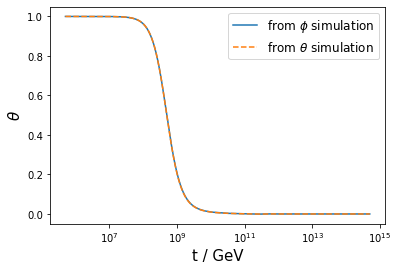

In [84]:
plt.semilogx(t, [phi_over_f_to_theta_fn(p) for p in phi_over_f], label="from $\\phi$ simulation")
plt.semilogx(sol_theta.t, sol_theta.y[0], ls="--", label="from $\\theta$ simulation")
plt.xlabel("t / GeV", fontsize=15)
plt.ylabel("$\\theta$", fontsize=15)
plt.legend(fontsize=12)

## Analytic Approximations